### Load libraries

In [1]:
import elegy as eg
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
import tensorflow as tf

jnp.arange(0)  # Prints out any jax warnings.

DeviceArray([], dtype=int32)

### Utilities

In [2]:
class MLP(eg.Module):
    def __init__(
        self,
        input_shape: tuple[int, ...],
        layer_widths: tuple[int, ...],
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.layer_widths = layer_widths
        self.input_shape = input_shape

    @eg.compact
    def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
        for w in self.layer_widths[:-1]:
            x = eg.Linear(
                w,
                kernel_init=eg.initializers.he_normal(),
            )(x)
            x = jax.nn.relu(x)

        x = eg.Linear(
            self.layer_widths[-1],
            kernel_init=eg.initializers.he_normal(),
        )(x)
        return x


def get_random_mlp(
    mlp: MLP,
    seed: int = 0,
) -> eg.Model:
    """
    [96, 192, 1] is from https://arxiv.org/pdf/2102.06701.pdf.
    """
    model = eg.Model(module=mlp, seed=seed)

    assert not model.initialized
    model.predict(jnp.zeros(mlp.input_shape))
    assert model.initialized

    return model

In [3]:
def unit_sq_sampling(side_samples: int):
    xs, ys = jnp.meshgrid(
        jnp.linspace(-1, 1, side_samples),
        jnp.linspace(-1, 1, side_samples),
    )
    return jnp.stack([xs, ys]).T


def get_model_img(
    model: eg.Model,
    side_samples: int,
) -> jnp.ndarray:
    XY = unit_sq_sampling(side_samples)
    assert XY.shape == (side_samples, side_samples, 2)

    return model.predict(XY).squeeze(-1)


def viz_model(
    model: eg.Model,
    side_samples: int,
) -> None:
    img = get_model_img(model=model, side_samples=side_samples)
    plt.imshow(img)

### Initialize teacher model

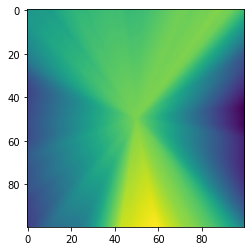

┏━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ path     ┃ module   ┃ params                                ┃ Parameter        ┃
┡━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ *        │ MLP()    │                                       │                  │
├──────────┼──────────┼───────────────────────────────────────┼──────────────────┤
│ .linear  │ Linear() │ bias: Parameter(96)           float32 │ 288      1.2KB   │
│          │          │ kernel: Parameter(2, 96)      float32 │                  │
├──────────┼──────────┼───────────────────────────────────────┼──────────────────┤
│ .linear2 │ Linear() │ bias: Parameter(192)          float32 │ 18,624   74.5KB  │
│          │          │ kernel: Parameter(96, 192)    float32 │                  │
├──────────┼──────────┼───────────────────────────────────────┼──────────────────┤
│ .linear3 │ Linear() │ bias: Parameter(1024)         float32 │ 197,632  790.5KB │
│          │          │ kernel: Parameter(192, 1024)  float32 │                  │
├──────────┼──────────┼───────────────────────────────────────┼──────────────────┤
│ .linear4 │ Linear() │ bias: Parameter(42)           float32 │ 43,050   172.2KB │
│          │          │ kernel: Parameter(1024, 42)   float32 │                  │
├──────────┼──────────┼───────────────────────────────────────┼──────────────────┤
│ .linear5 │ Linear() │ bias: Parameter(5)            float32 │ 215      860B    │
│          │          │ kernel: Parameter(42, 5)      float32 │                  │
├──────────┼──────────┼───────────────────────────────────────┼──────────────────┤
│ .linear6 │ Linear() │ bias: Parameter(1)            float32 │ 6        24B     │
│          │          │ kernel: Parameter(5, 1)       float32 │                  │
├──────────┼──────────┼───────────────────────────────────────┼──────────────────┤
│          │          │                                Total: │ 259,815  1.0MB   │
└──────────┴──────────┴───────────────────────────────────────┴──────────────────┘
                                                                                  
                         Total Parameters: 259,815  1.0MB                         

In [4]:
TEACHER_MODULE = MLP(
    input_shape=(2,),
    layer_widths=[96, 192, 1024, 42, 5, 1],
)

TEACHER = get_random_mlp(mlp=TEACHER_MODULE, seed=-1)
viz_model(TEACHER, side_samples=100)
plt.show()
TEACHER.summary()

### Create dataset

In [5]:
def get_iid_dataset(
    model: eg.Model,
    n_samples: int,
    rng: jax.random.KeyArray,
) -> tf.data.Dataset:
    xs = jax.random.uniform(
        minval=-1,
        maxval=1,
        shape=(n_samples,) + model.module.input_shape,
        key=rng,
    )

    # TODO: Batch this in case it doesn't fit in memory
    ys = model.predict(xs)

    return dict(xs=xs, ys=ys)


DS_TEST = get_iid_dataset(
    model=TEACHER,
    n_samples=2048,
    rng=jax.random.PRNGKey(-1),
)
DS_TEST["xs"][:5], DS_TEST["ys"][:5]

(DeviceArray([[-0.7362349 , -0.7916355 ],
              [ 0.8269553 ,  0.9081223 ],
              [ 0.46209455, -0.895056  ],
              [-0.996356  , -0.551285  ],
              [-0.29463196,  0.06764483]], dtype=float32),
 DeviceArray([[-0.26464108],
              [-0.52757984],
              [-0.59837955],
              [-0.1767205 ],
              [-0.02328737]], dtype=float32))

### Initialize and train student model

In [6]:
STUDENT = eg.Model(
    module=TEACHER_MODULE,
    seed=42,
    loss=[
        eg.losses.MeanSquaredError(),
        # eg.regularizers.GlobalL2(l=1e-4),
    ],
    #metrics=eg.metrics,
    optimizer=optax.adam(1e-3),
)

In [7]:
DS_TRAIN = get_iid_dataset(
    model=TEACHER,
    n_samples=50000,
    rng=jax.random.PRNGKey(44),
)

history = STUDENT.fit(
    inputs=DS_TRAIN["xs"],
    labels=DS_TRAIN["ys"],
    validation_data=(DS_TEST["xs"], DS_TEST["ys"]),
    batch_size=128,
    shuffle=True,
    epochs=100,
    callbacks=[eg.callbacks.EarlyStopping(monitor="loss", patience=3)],
)

Epoch 1/100
390/391 [============================>.] - 7s 17ms/step - loss: 0.0373 - mean_squared_error_loss: 0.0373 - val_loss: 0.0017 - val_mean_squared_error_loss: 0.0017
Epoch 2/100
390/391 [============================>.] - 2s 6ms/step - loss: 0.0011 - mean_squared_error_loss: 0.0011 - val_loss: 8.1299e-04 - val_mean_squared_error_loss: 8.1299e-04
Epoch 3/100
390/391 [============================>.] - 2s 6ms/step - loss: 5.9758e-04 - mean_squared_error_loss: 5.9758e-04 - val_loss: 6.0952e-04 - val_mean_squared_error_loss: 6.0952e-04
Epoch 4/100
390/391 [============================>.] - 3s 7ms/step - loss: 4.2586e-04 - mean_squared_error_loss: 4.2586e-04 - val_loss: 8.1365e-04 - val_mean_squared_error_loss: 8.1365e-04
Epoch 5/100
390/391 [============================>.] - 3s 7ms/step - loss: 4.4051e-04 - mean_squared_error_loss: 4.4051e-04 - val_loss: 9.1885e-05 - val_mean_squared_error_loss: 9.1885e-05
Epoch 6/100
390/391 [============================>.] - 3s 7ms/step - loss: 1.1

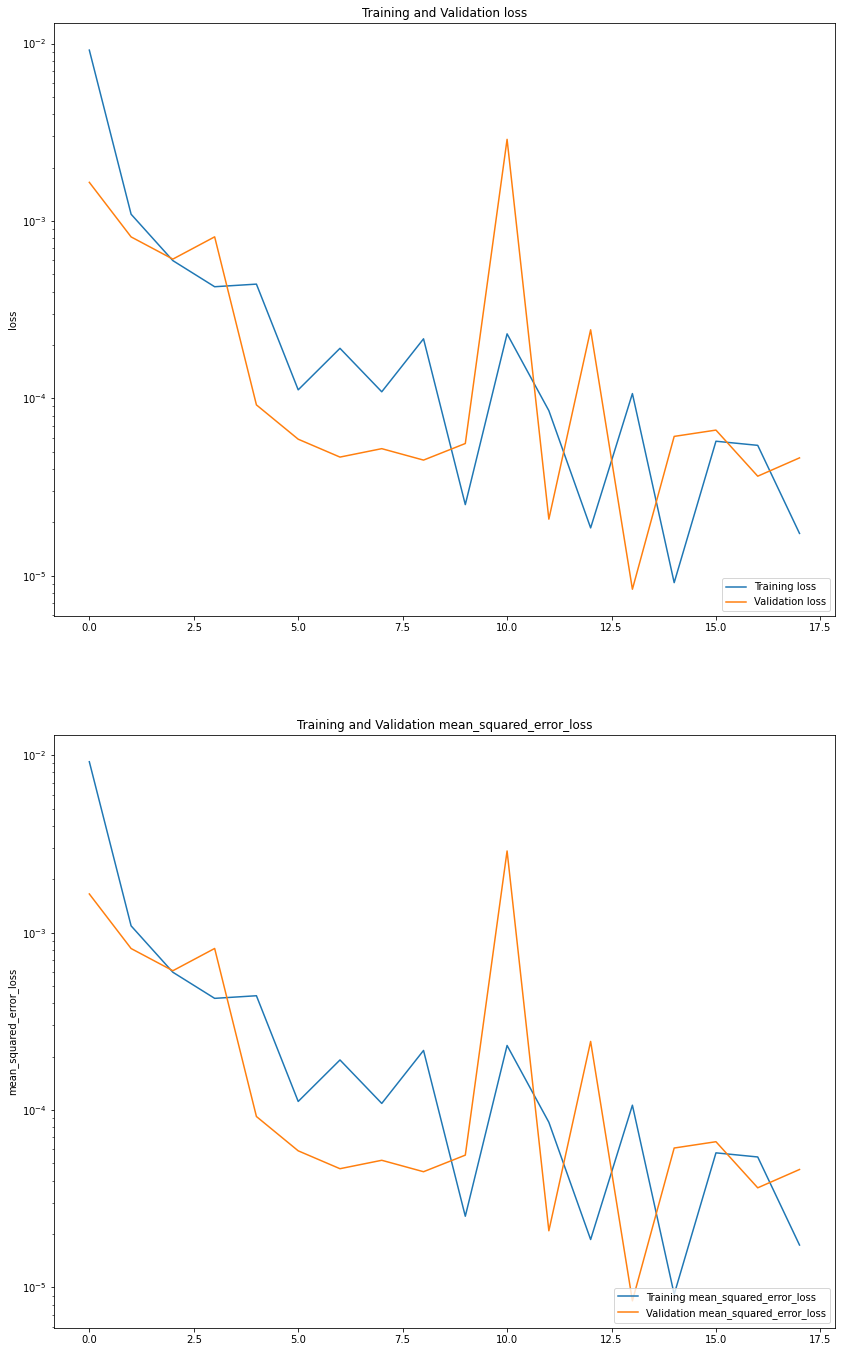

In [8]:
def plot_history(history):
    n_plots = len(history.history.keys()) // 2
    plt.figure(figsize=(14, 24))
    
    for i, key in enumerate(list(history.history.keys())[:n_plots]):
        metric = history.history[key]
        val_metric = history.history[f"val_{key}"]

        plt.subplot(n_plots, 1, i + 1)
        plt.plot(metric, label=f"Training {key}")
        plt.plot(val_metric, label=f"Validation {key}")
        plt.legend(loc="lower right")
        plt.ylabel(key)
        plt.title(f"Training and Validation {key}")
        plt.yscale("log")
    plt.show()
    
plot_history(history)

Text(0.5, 1.0, 'STUDENT')

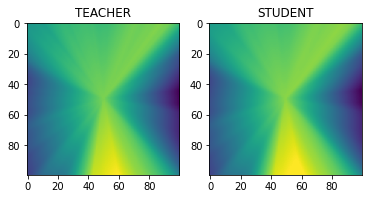

In [9]:
plt.subplot(1, 2, 1)
viz_model(TEACHER, side_samples=100)
plt.title("TEACHER")

plt.subplot(1, 2, 2)
viz_model(STUDENT, side_samples=100)
plt.title("STUDENT")